In [316]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

In [317]:
import os

base_dir = os.path.abspath('')
path = os.path.join(base_dir, '../Przetwarzanie Danych/')
co2_production = pd.read_csv(path + 'co2_production.csv')
gni_per_capita = pd.read_csv(path + 'gross_national_income_per_capital.csv')
hdi = pd.read_csv(path + 'human_development_index.csv')
life_expectancy = pd.read_csv(path + 'life_expectancy_by_birth.csv')

all_data = life_expectancy.copy()

In [318]:
for dataframe in [co2_production, gni_per_capita, hdi]:
    all_data = all_data.merge(dataframe, on='Country', how='outer', suffixes=('', '_drop'))

all_data = all_data[all_data.columns.drop(list(all_data.filter(regex='_drop')))]

columns_to_drop = ['ISO3', 'hdicode', 'hdi_rank_2021']
all_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')


all_data['avg_co2'] = all_data.filter(like='co2_prod_').mean(axis=1)
all_data['avg_gni'] = all_data.filter(like='gnipc_').mean(axis=1)  

In [319]:
for year in range(1990, 2022):
    co2_column_name = f"co2_prod_{year}"
    gni_column_name = f"gnipc_{year}"
    estimated_population_column_name = f"estimated_population_{year}"
    co2_per_capita_column_name = f"co2_per_capita_{year}"
    
    if co2_column_name in all_data.columns and gni_column_name in all_data.columns:
        all_data[estimated_population_column_name] = all_data[co2_column_name] / all_data[gni_column_name]
        all_data[co2_per_capita_column_name] = all_data[co2_column_name] / all_data[estimated_population_column_name]


print(all_data['avg_co2'].describe())
print(all_data['avg_gni'].describe())

count    204.000000
mean       4.499696
std        5.972266
min        0.038186
25%        0.639804
50%        2.227585
75%        6.370562
max       48.440912
Name: avg_co2, dtype: float64
count       204.000000
mean      16488.239856
std       18703.085972
min         841.037957
25%        3768.881573
50%        9515.751330
75%       20114.611191
max      111709.939782
Name: avg_gni, dtype: float64


In [320]:
all_data['co2_gni_interaction'] = all_data['avg_co2'] * all_data['avg_gni']

In [321]:
for col in all_data.columns:
    if all_data[col].dtype == 'object':
        all_data[col].fillna(all_data[col].mode()[0], inplace=True)
    else:
        all_data[col].fillna(all_data[col].mean(), inplace=True)

encoder = OneHotEncoder(drop='first')
encoded_region = encoder.fit_transform(all_data[['region']])
encoded_region_df = pd.DataFrame(encoded_region.toarray(), columns=encoder.get_feature_names_out(['region']))
all_data = pd.concat([all_data.drop(['region'], axis=1), encoded_region_df], axis=1)

In [322]:
pd.set_option('display.max_columns', None)

In [323]:
all_data

,Country,le_1990,le_1991,le_1992,le_1993,le_1994,le_1995,le_1996,le_1997,le_1998,le_1999,le_2000,le_2001,le_2002,le_2003,le_2004,le_2005,le_2006,le_2007,le_2008,le_2009,le_2010,le_2011,le_2012,le_2013,le_2014,le_2015,le_2016,le_2017,le_2018,le_2019,le_2020,le_2021,co2_prod_1990,co2_prod_1991,co2_prod_1992,co2_prod_1993,co2_prod_1994,co2_prod_1995,co2_prod_1996,co2_prod_1997,co2_prod_1998,co2_prod_1999,co2_prod_2000,co2_prod_2001,co2_prod_2002,co2_prod_2003,co2_prod_2004,co2_prod_2005,co2_prod_2006,co2_prod_2007,co2_prod_2008,co2_prod_2009,co2_prod_2010,co2_prod_2011,co2_prod_2012,co2_prod_2013,co2_prod_2014,co2_prod_2015,co2_prod_2016,co2_prod_2017,co2_prod_2018,co2_prod_2019,co2_prod_2020,co2_prod_2021,gnipc_1990,gnipc_1991,gnipc_1992,gnipc_1993,gnipc_1994,gnipc_1995,gnipc_1996,gnipc_1997,gnipc_1998,gnipc_1999,gnipc_2000,gnipc_2001,gnipc_2002,gnipc_2003,gnipc_2004,gnipc_2005,gnipc_2006,gnipc_2007,gnipc_2008,gnipc_2009,gnipc_2010,gnipc_2011,gnipc_2012,gnipc_2013,gnipc_2014,gnipc_2015,gnipc_2016,gnipc_2017,gnipc_2018,gnipc_2019,gnipc_2020,gnipc_2021,hdi_1990,hdi_1991,hdi_1992,hdi_1993,hdi_1994,hdi_1995,hdi_1996,hdi_1997,hdi_1998,hdi_1999,hdi_2000,hdi_2001,hdi_2002,hdi_2003,hdi_2004,hdi_2005,hdi_2006,hdi_2007,hdi_2008,hdi_2009,hdi_2010,hdi_2011,hdi_2012,hdi_2013,hdi_2014,hdi_2015,hdi_2016,hdi_2017,hdi_2018,hdi_2019,hdi_2020,hdi_2021,avg_co2,avg_gni,estimated_population_1990,co2_per_capita_1990,estimated_population_1991,co2_per_capita_1991,estimated_population_1992,co2_per_capita_1992,estimated_population_1993,co2_per_capita_1993,estimated_population_1994,co2_per_capita_1994,estimated_population_1995,co2_per_capita_1995,estimated_population_1996,co2_per_capita_1996,estimated_population_1997,co2_per_capita_1997,estimated_population_1998,co2_per_capita_1998,estimated_population_1999,co2_per_capita_1999,estimated_population_2000,co2_per_capita_2000,estimated_population_2001,co2_per_capita_2001,estimated_population_2002,co2_per_capita_2002,estimated_population_2003,co2_per_capita_2003,estimated_population_2004,co2_per_capita_2004,estimated_population_2005,co2_per_capita_2005,estimated_population_2006,co2_per_capita_2006,estimated_population_2007,co2_per_capita_2007,estimated_population_2008,co2_per_capita_2008,estimated_population_2009,co2_per_capita_2009,estimated_population_2010,co2_per_capita_2010,estimated_population_2011,co2_per_capita_2011,estimated_population_2012,co2_per_capita_2012,estimated_population_2013,co2_per_capita_2013,estimated_population_2014,co2_per_capita_2014,estimated_population_2015,co2_per_capita_2015,estimated_population_2016,co2_per_capita_2016,estimated_population_2017,co2_per_capita_2017,estimated_population_2018,co2_per_capita_2018,estimated_population_2019,co2_per_capita_2019,estimated_population_2020,co2_per_capita_2020,estimated_population_2021,co2_per_capita_2021,co2_gni_interaction,region_EAP,region_ECA,region_LAC,region_SA,region_SSA
0,Afghanistan,45.967200,46.663100,47.595500,51.466400,51.494500,52.544200,53.243300,53.634200,52.943100,54.846400,55.297800,55.798100,56.453800,57.344500,57.943600,58.360800,58.684400,59.111300,59.851500,60.363600,60.850800,61.419100,61.923000,62.416700,62.545100,62.658700,63.136100,63.016000,63.081000,63.564500,62.575100,61.982400,0.209727,0.182525,0.095233,0.084285,0.075054,0.067943,0.061787,0.056005,0.052144,0.040133,0.036462,0.036931,0.046529,0.050083,0.035960,0.050802,0.061870,0.083711,0.151485,0.237367,0.287739,0.401954,0.327922,0.261571,0.232967,0.229680,0.190617,0.188995,0.224492,0.319299,0.312376,0.312376,2684.550019,2276.289409,2059.868084,1525.533426,1087.961890,1339.087122,1332.307210,1230.261290,1149.902390,1071.800919,984.997434,894.024589,1267.628852,1401.324413,1384.695729,1435.191730,1518.767846,1811.166659,1753.066993,1884.200863,1938.315627,1999.653042,2125.862821,2193.553936,2178.507021,2101.589319,2077.566899,2085.487571,2054.939895,2097.889450,1997.852149,1824.190915,0.273000,0.279000,0.287000,0.297000,0.292000,0.310000,0.319000,0.323000,0.324000,

In [324]:
df = pd.DataFrame(columns=["co2", "gnipc", "hdi", "region_EAP",	"region_ECA", "region_LAC", "region_SA", "region_SSA", "le"])
df


,co2,gnipc,hdi,region_EAP,region_ECA,region_LAC,region_SA,region_SSA,le


In [325]:
index = 0

for i, row in all_data.iterrows():
    for year in range(1990, 2022):
        new_row = {
            'co2': row[f'co2_per_capita_{year}'],
            'hdi': row[f'hdi_{year}'],
            'le': row[f'le_{year}'],
            'gnipc': row[f'gnipc_{year}'],
            'region_EAP': row['region_EAP'],
            'region_ECA': row['region_ECA'],
            'region_LAC': row['region_LAC'],
            'region_SA': row['region_SA'],
            'region_SSA': row['region_SSA']
        }

        df.loc[index] = new_row
        index += 1

In [326]:
df

,co2,gnipc,hdi,region_EAP,region_ECA,region_LAC,region_SA,region_SSA,le
0,2684.550019,2684.550019,0.273,0.0,0.0,0.0,1.0,0.0,45.967200
1,2276.289409,2276.289409,0.279,0.0,0.0,0.0,1.0,0.0,46.663100
2,2059.868084,2059.868084,0.287,0.0,0.0,0.0,1.0,0.0,47.595500
3,1525.533426,1525.533426,0.297,0.0,0.0,0.0,1.0,0.0,51.466400
4,1087.961890,1087.961890,0.292,0.0,0.0,0.0,1.0,0.0,51.494500
...,...,...,...,...,...,...,...,...,...
6587,16022.410060,16022.410060,0.733,0.0,0.0,0.0,0.0,1.0,72.568952
6588,16372.224530,16372.224530,0.736,0.0,0.0,0.0,0.0,1.0,72.816114
6589,16652.533510,16652.533510,0.739,0.0,0.0,0.0,0.0,1.0,73.012099
6590,15963.888970,15963.888970,0.735,0.0,0.0,0.0,0.0,1.0,72.257297


In [327]:
features = df.drop('le', axis=1)
target = df['le']

In [328]:
numeric_columns = features.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
features[numeric_columns] = scaler.fit_transform(features[numeric_columns])

In [329]:
features

,co2,gnipc,hdi,region_EAP,region_ECA,region_LAC,region_SA,region_SSA
0,0.015494,0.015494,0.076408,0.0,0.0,0.0,1.0,0.0
1,0.012705,0.012705,0.084450,0.0,0.0,0.0,1.0,0.0
2,0.011227,0.011227,0.095174,0.0,0.0,0.0,1.0,0.0
3,0.007578,0.007578,0.108579,0.0,0.0,0.0,1.0,0.0
4,0.004589,0.004589,0.101877,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
6587,0.106591,0.106591,0.693029,0.0,0.0,0.0,0.0,1.0
6588,0.108980,0.108980,0.697051,0.0,0.0,0.0,0.0,1.0
6589,0.110895,0.110895,0.701072,0.0,0.0,0.0,0.0,1.0
6590,0.106191,0.106191,0.695710,0.0,0.0,0.0,0.0,1.0


In [330]:
target

0       45.967200
1       46.663100
2       47.595500
3       51.466400
4       51.494500
          ...    
6587    72.568952
6588    72.816114
6589    73.012099
6590    72.257297
6591    71.365465
Name: le, Length: 6592, dtype: float64

In [331]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [332]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [347]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(features.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

In [348]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [349]:
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.2)

Epoch 1/200
264/264 [==============================] - 1s 1ms/step - loss: 1028.1415 - val_loss: 47.9497
Epoch 2/200
264/264 [==============================] - 0s 1ms/step - loss: 80.9689 - val_loss: 31.4927
Epoch 3/200
264/264 [==============================] - 0s 1ms/step - loss: 71.6371 - val_loss: 27.4098
Epoch 4/200
264/264 [==============================] - 0s 1ms/step - loss: 67.0147 - val_loss: 25.9726
Epoch 5/200
264/264 [==============================] - 0s 1ms/step - loss: 63.5974 - val_loss: 26.1307
Epoch 6/200
264/264 [==============================] - 0s 1ms/step - loss: 61.2191 - val_loss: 27.2227
Epoch 7/200
264/264 [==============================] - 0s 1ms/step - loss: 56.6787 - val_loss: 32.2532
Epoch 8/200
264/264 [==============================] - 0s 1ms/step - loss: 53.9860 - val_loss: 27.1534
Epoch 9/200
264/264 [==============================] - 0s 1ms/step - loss: 49.4135 - val_loss: 30.9413
Epoch 10/200
264/264 [==============================] - 0s 1ms/step - l

range(2, 201)


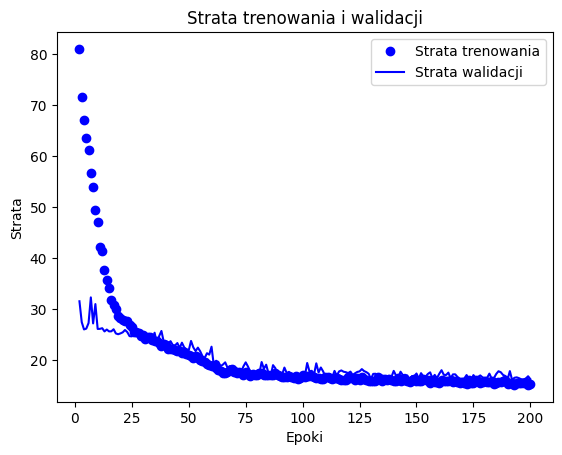

In [350]:
start = 2
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(start, len(loss) + 1)
print(epochs)
plt.plot(epochs, loss[start-1:], 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss[start-1:], 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

range(100, 201)


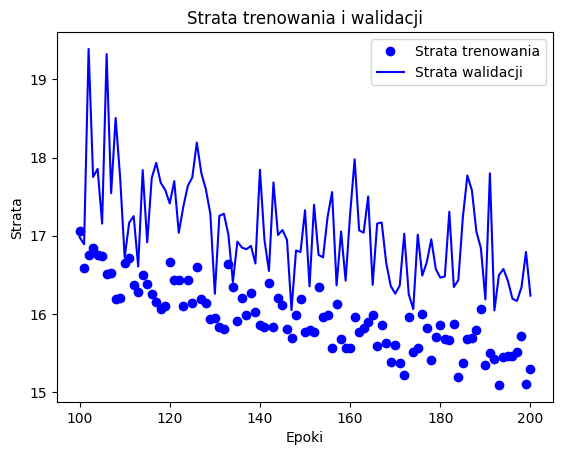

In [351]:
start = 100
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(start, len(loss) + 1)
print(epochs)
plt.plot(epochs, loss[start-1:], 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss[start-1:], 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

In [352]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

42/42 [==============================] - 0s 646us/step - loss: 14.1089
Test Loss: 14.108930587768555


In [353]:
predictions = model.predict(X_test)

42/42 [==============================] - 0s 659us/step


In [354]:
p_df = pd.DataFrame(columns=['Prediction', 'Actual', 'Difference'])

for i, prediction in enumerate(predictions):
    pred = prediction[0]
    act = y_test.values[i]
    diff = pred - act

    p_df.loc[i] = {
        'Prediction': pred,
        'Actual': act,
        'Difference': abs(diff)
    }

In [355]:
p_df

,Prediction,Actual,Difference
0,79.513046,81.7003,2.187254
1,70.153015,69.6487,0.504315
2,67.433914,68.1382,0.704286
3,78.021690,77.8991,0.122590
4,67.525635,63.5178,4.007835
...,...,...,...
1314,49.208664,43.3876,5.821064
1315,58.597263,59.6739,1.076637
1316,72.964981,73.9313,0.966319
1317,73.697891,75.7861,2.088209


In [356]:
p_df.describe()

,Prediction,Actual,Difference
count,1319.000000,1319.000000,1319.000000
mean,68.166237,68.173354,2.592964
std,8.206660,9.388494,2.718652
min,46.141872,30.147900,0.000920
25%,62.443542,61.650200,0.876877
50%,69.642303,70.125000,1.874224
75%,74.400520,75.090750,3.390414
max,82.086594,86.464300,30.761894


In [358]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

actual_values = p_df['Actual']
predicted_values = p_df['Prediction']

In [359]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predicted_values)

# MSE mierzy średnią kwadratową różnicę między przewidzianymi a rzeczywistymi wartościami.
# MSE karze błędy większe bardziej niż błędy mniejsze. Jest czułe na wartości odstające.

# Calculate Mean Absolute Error (MAE)

mae = mean_absolute_error(actual_values, predicted_values)

# MAE mierzy średnią bezwzględną różnicę między przewidzianymi a rzeczywistymi wartościami.
# MAE jest mniej wyczulone na wartości odstające w porównaniu z MSE.


# Calculate R-squared (R2) score
r2 = r2_score(actual_values, predicted_values)

# R2 mierzy proporcję wariancji zmiennej zależnej, która jest przewidywalna na podstawie zmiennych niezależnych.
# przyjmuje wartości od 0 do 1, gdzie 1 oznacza idealne dopasowanie.


In [360]:
# Display the results
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2) Score: {r2}')

# MSE i MAE są dobrym narzedziem do oceny wyników regresji, przy czym MSE jest bardziej czułe na większe błędy
# R2 może dostarczyć ogólnej miary dopasowania modelu, podczas gdy MSE i MAE mogą ułatwić zrozumienie wielkości błędów.

Mean Squared Error (MSE): 14.108928162353855
Mean Absolute Error (MAE): 2.5929644928205033
R-squared (R2) Score: 0.8398114289516364
